<a href="https://colab.research.google.com/github/sahithya17b/Air-Quality/blob/main/Day_19_and_Milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Training samples: 236966 | Testing samples: 59242

📘 Training ARIMA Models...

🟩 Training XGBoost Models...

📈 Model Evaluation Results:
  Model Target       MAE      RMSE         MAPE        R²
  ARIMA  pm2.5  7.881514  9.487211 8.009625e+06 -0.275557
  ARIMA    aqi 15.779084 19.302989 3.890566e+01 -0.093125
XGBoost  pm2.5  2.359206  3.248198 1.324324e+06  0.850477
XGBoost    aqi  0.947541  2.416318 2.245635e+00  0.982871

🏁 Best Models (Lowest RMSE per Target):
  Model Target      MAE     RMSE         MAPE       R²
XGBoost    aqi 0.947541 2.416318 2.245635e+00 0.982871
XGBoost  pm2.5 2.359206 3.248198 1.324324e+06 0.850477


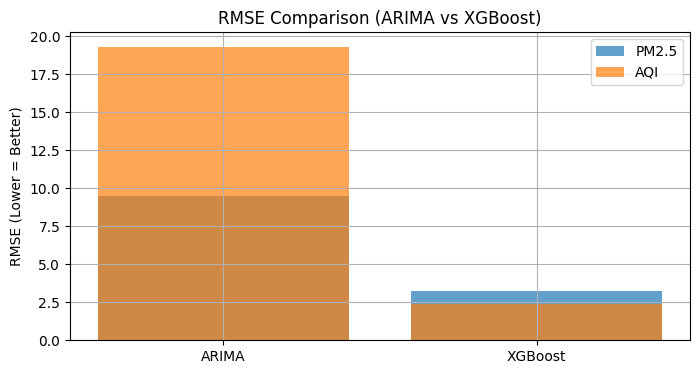

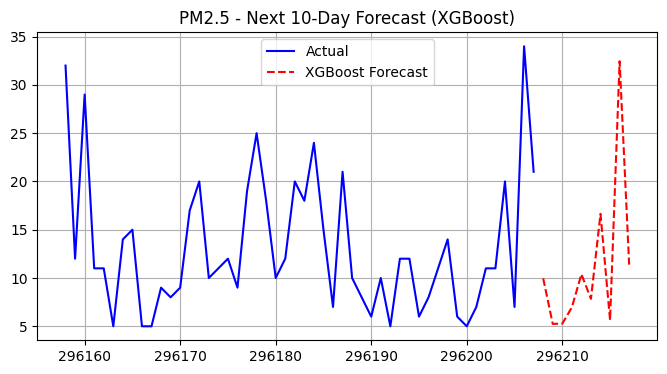

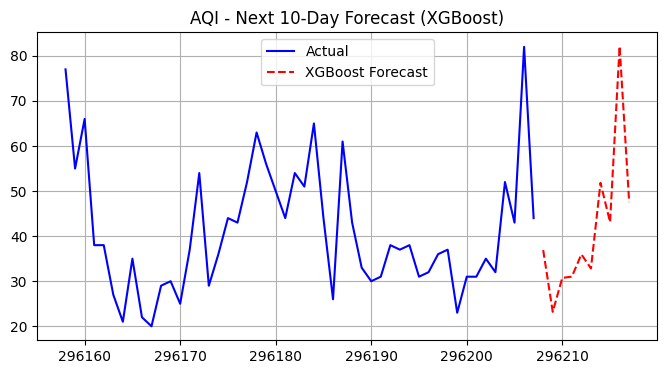


✅ Forecasts saved to: best_model_forecasts.csv


In [1]:
# ============================================================
# 🌍 AIR QUALITY FORECASTING COMPARISON (ARIMA vs XGBoost)
# Split: 80% Training | 20% Testing
# Metrics: MAE | RMSE | MAPE | R²
# Forecast: Next 10 Days for PM2.5 and AQI
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

# === Load and Prepare Data ===
path = "/content/cleaned numeric.csv"   # change if needed
df = pd.read_csv(path)
df = df.select_dtypes(include=[np.number]).fillna(method='ffill').fillna(method='bfill')

targets = ['pm2.5', 'aqi']
features = [c for c in df.columns if c not in targets]

# 80:20 Split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
print(f"✅ Training samples: {len(train)} | Testing samples: {len(test)}")

# === Metrics Function ===
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

results = []
forecasts = {}

# ============================================================
# 1️⃣ ARIMA
# ============================================================
print("\n📘 Training ARIMA Models...")
for target in targets:
    series = df[target].fillna(method='ffill')
    train_series = series[:train_size]
    test_series = series[train_size:]

    model = ARIMA(train_series, order=(2,1,2))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_series))

    mae, rmse, mape, r2 = evaluate(test_series, forecast)
    results.append(['ARIMA', target, mae, rmse, mape, r2])
    forecasts[f"ARIMA_{target}"] = model_fit.forecast(steps=10)

# ============================================================
# 2️⃣ XGBOOST
# ============================================================
print("\n🟩 Training XGBoost Models...")
for target in targets:
    X_train, X_test = train[features], test[features]
    y_train, y_test = train[target], test[target]

    model_xgb = XGBRegressor(
        n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42
    )
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_test)

    mae, rmse, mape, r2 = evaluate(y_test, y_pred)
    results.append(['XGBoost', target, mae, rmse, mape, r2])

    # Forecast next 10 days (based on last known 10 samples)
    last_features = df[features].iloc[-10:].values
    forecasts[f"XGBoost_{target}"] = model_xgb.predict(last_features)

# ============================================================
# 📊 Final Comparison
# ============================================================
results_df = pd.DataFrame(results, columns=['Model', 'Target', 'MAE', 'RMSE', 'MAPE', 'R²'])
print("\n📈 Model Evaluation Results:")
print(results_df.to_string(index=False))

# ============================================================
# 🏁 Best Models (Lowest RMSE)
# ============================================================
print("\n🏁 Best Models (Lowest RMSE per Target):")
best_models = results_df.loc[results_df.groupby('Target')['RMSE'].idxmin()].reset_index(drop=True)
print(best_models.to_string(index=False))

# ============================================================
# 📉 RMSE Visualization
# ============================================================
plt.figure(figsize=(8,4))
for target in targets:
    subset = results_df[results_df['Target']==target]
    plt.bar(subset['Model'], subset['RMSE'], alpha=0.7, label=target.upper())
plt.title("RMSE Comparison (ARIMA vs XGBoost)")
plt.ylabel("RMSE (Lower = Better)")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 🔮 Forecast Visualization + Save CSV
# ============================================================
forecast_output = []
for target in targets:
    best_model = best_models.loc[best_models['Target']==target, 'Model'].values[0]
    forecast = forecasts[f"{best_model}_{target}"]

    forecast_output.append(pd.DataFrame({
        'Target': target,
        'Model': best_model,
        'Day': np.arange(1, 11),
        'Forecast': forecast
    }))

    plt.figure(figsize=(8,4))
    plt.plot(df[target].iloc[-50:], label="Actual", color='blue')
    plt.plot(range(len(df), len(df)+10), forecast, label=f"{best_model} Forecast", color='red', linestyle='--')
    plt.title(f"{target.upper()} - Next 10-Day Forecast ({best_model})")
    plt.legend()
    plt.grid(True)
    plt.show()

forecast_df = pd.concat(forecast_output, ignore_index=True)
forecast_df.to_csv("best_model_forecasts.csv", index=False)
print("\n✅ Forecasts saved to: best_model_forecasts.csv")
